In [1]:
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, './CFE')
import bmi_cfe_statevars

print(bmi_cfe_statevars)


<module 'bmi_cfe_statevars' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./CFE\\bmi_cfe_statevars.py'>


In [2]:
cfe_instance = bmi_cfe_statevars.BMI_CFE() #one that changes state vars
print("CFE")
print(cfe_instance.get_input_var_names())
print()
print(cfe_instance.get_output_var_names())


CFE
['atmosphere_water__time_integral_of_precipitation_mass_flux', 'water_potential_evaporation_flux', 'state_var_change_soil', 'state_var_change_runoff']

['land_surface_water__runoff_depth', 'land_surface_water__runoff_volume_flux', 'DIRECT_RUNOFF', 'GIUH_RUNOFF', 'NASH_LATERAL_RUNOFF', 'DEEP_GW_TO_CHANNEL_FLUX']


### This initialization function should perform all tasks that are to take place before entering the model’s time loop. Models should be refactored, if necessary, to read their inputs (which could include filenames for other input files) from a configuration file. BMI does not impose any constraint on how configuration files are formatted.

In [3]:
cfe_instance.initialize(cfg_file='./CFE/cat_58_config_cfe.json')
#cfe_instance.initialize(cfg_file='./CFE/config_cfe.json')
cfe_instance.forcing_file # path to forcing file


'./Forcing/forcing_data_01May07.csv'

### Open the forcing file contained within the configuration file. We can run the model with any forcing. This is only an example. The path to the forcing file is contained within the configuration file, but it doesn't really need to be. This is just for organization.

In [4]:
with open(cfe_instance.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)
    
print(df_forcing)

                time  RAINRATE      T2D       Q2D     U2D     V2D       PSFC  \
0      5/1/2007 0:00  0.000000  287.524  0.005954  6.8022 -5.9622   98865.18   
1      5/1/2007 1:00  0.000000  286.360  0.005718  5.9674 -5.5988   98958.90   
2      5/1/2007 2:00  0.000000  285.190  0.005476  5.1368 -5.2316   99052.70   
3      5/1/2007 3:00  0.000000  284.028  0.005236  4.3022 -4.8690   99145.68   
4      5/1/2007 4:00  0.000000  283.386  0.005224  4.1124 -4.7622   99204.96   
..               ...       ...      ...       ...     ...     ...        ...   
739  5/31/2007 19:00  0.000000  298.876  0.015622 -3.0062  1.4038  100296.90   
740  5/31/2007 20:00  0.000000  298.920  0.015804 -2.9102  1.3286  100205.00   
741  5/31/2007 21:00  0.000000  298.962  0.015976 -2.8106  1.2480  100113.76   
742  5/31/2007 22:00  0.000000  296.786  0.014962 -2.7040  1.0918  100129.94   
743  5/31/2007 23:00  0.000102  294.600  0.013988 -2.6036  0.9400  100145.58   

      SWDOWN   LWDOWN  
0      0.000  2

### We will want to visualize the model output

In [5]:
# Originial CFE Model
cfe_outputs=cfe_instance.get_output_var_names()
cfe_output_lists = {output:[] for output in cfe_outputs}

print(cfe_output_lists)


{'land_surface_water__runoff_depth': [], 'land_surface_water__runoff_volume_flux': [], 'DIRECT_RUNOFF': [], 'GIUH_RUNOFF': [], 'NASH_LATERAL_RUNOFF': [], 'DEEP_GW_TO_CHANNEL_FLUX': []}


### Now we loop through the forcing data and use it to run the model at each time step

In [7]:
cfe_list = []

percent_list = np.arange(10, 200, 10)
percentList = percent_list.tolist() #to list for dataframe

for percent in percent_list:
    
    percent=percent/100 #convert to percentage    
    cfe_instance.set_value('state_var_change_runoff', percent) #value of precip from forcing data in loop
    #runoff is the runoff_queue_m_per_timestep
    #soil is soil_reservoir_storage_deficit_m
    
    for i, precip in enumerate(df_forcing['APCP_surface']): #i is 
    #for i, precip in enumerate(df_forcing['RAINRATE']):

        framework_time = (1+i)*3600 #seconds since starting simulation

        # Run CFE model
        cfe_instance.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) #value of precip from forcing data in loop
        cfe_instance.update()
        outflow = cfe_instance.get_value('land_surface_water__runoff_depth')
    cfe_list.append(np.mean(outflow))

df = pd.DataFrame({'Percent_Change':percentList,'Mean_Streamflow':cfe_list})
matrix = df.to_numpy() #convert to matirx
#print(matrix)
print(df)



    Percent_Change  Mean_Streamflow
0               10         0.000083
1               20         0.000167
2               30         0.000250
3               40         0.000334
4               50         0.000417
5               60         0.000501
6               70         0.000584
7               80         0.000667
8               90         0.000751
9              100         0.000834
10             110         0.000918
11             120         0.001001
12             130         0.001085
13             140         0.001168
14             150         0.001252
15             160         0.001335
16             170         0.001418
17             180         0.001502
18             190         0.001585


y = 1.003157894736842x + -0.6842105263158353


,Percent_Change,Mean_Streamflow
0,10,9.0
1,20,19.0
2,30,30.0
3,40,39.0
4,50,50.0
5,60,60.0
6,70,69.0
7,80,79.0
8,90,90.0
9,100,100.0


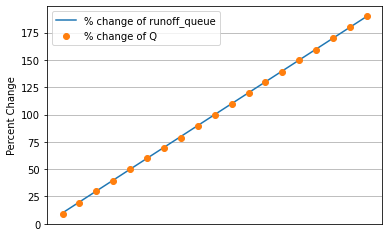

In [8]:
no_change = df.loc[df['Percent_Change'] == 100]
# # # # # no_change['Sum streamflow']
Q_at_no_change=float(no_change['Mean_Streamflow'])
# # # # # float(Q_at_no_change)
df['Mean_Streamflow']=100*df['Mean_Streamflow']//Q_at_no_change

x = df.iloc[:,0]
y = df.iloc[:,1]
m, b = np.polyfit(x,y,1)

print('y = %sx + %s' %(m, b))

# # # #df['Sum streamflow'][100]
# # # # df['Sum streamflow']#/Q_at_no_change
plt.plot(df['Percent_Change'],label='% change of runoff_queue', color='tab:blue')
plt.plot(df['Mean_Streamflow'], 'o', label='% change of Q', color = 'tab:orange')
plt.xticks([])
plt.ylabel('Percent Change')
plt.legend(loc=2)
plt.grid()
df

In [ ]:
# Find mean streamflow to based changes on
# df_mean = df['Sum_streamflow'].mean()
#print('The Mean streamflow is %s' %(df_mean))

# If statement to add group to assocaited percent range 
df.loc[df['Percentage'] <=0.25,'Group'] = 1
df.loc[(df['Percentage'] > 0.25) & (df['Percentage'] <= 0.5),'Group'] = 2
df.loc[(df['Percentage'] > 0.5) & (df['Percentage'] <= 1.0),'Group'] = 3
df.loc[(df['Percentage'] > 1.0) & (df['Percentage'] <= 1.5),'Group'] = 4
df.loc[(df['Percentage'] > 1.5) & (df['Percentage'] <= 2.0),'Group'] = 5

# Test runoff
runoff_queue_m_per_timestep = 1
df.loc[(df['Group'] == 3), 'runoff_queue_m_per_timestep'] = runoff_queue_m_per_timestep * 0.1
#print(df)